# Detecting Fraudulent claims in Banksim
This notebook tries to create a supervised learning model to detect fraudulent transactions in the BankSim dataset provided by https://www.kaggle.com/ntnu-testimon/banksim1 

The goal is to first create a benchmark model on the intrinsic features provided, the dataset will then be modeled as a graph using a Neo4j database to be able to apply graph theory algorithms in order of creating network features to feed into the model. 

### Implementation steps
The steps for creating the model are as follows:  
1. Preprocess data to be able to feed into predictive model
 1. Remove rows with empty values
 2. Normalize feature values
2. Train supervised learning model
 1. Split data into 5 folds, to use for cross validation
 2. Estimate model prediction error using K-fold cross validation
 3. Choose best performing model
 4. Optimize hyperparameters using grid search
3. Measure performance of final optimized model %on intrinsic features
4. Create graph data model 
5. Apply graph algorithms to create network features
6. Add network features to preprocessed dataset from step 1
7. Retrain supervised learning model with additional features using same method from step 2
8. Measure performance of model with network features and compare to metrics from step 3
9. Quantify performance gains

## Data Exploration
This section will provide some basic exploration of the dataset in question

In [21]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
%matplotlib inline 

In [23]:
df = pd.read_csv("/Users/victorode/Developer/Python/Neo4j/Neo4jProject/Fraud Detection Model/data/bs140513_032310.csv")
df.head()

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0


As seen above, the data consists of 10 fields, 9 input features and one label noting if the datapoint is fraudulent or not

### Number of unique values
Exploring how many unique values there are for each feature

In [24]:
unique_print_str =  ""
for column in df:
    unique_print_str += " |{}: {}| ".format(column, df[column].unique().size)
    #print(df[column].unique().size)
print('---------- Number of unique values per feature ----------')
print(unique_print_str)

---------- Number of unique values per feature ----------
 |step: 180|  |customer: 4112|  |age: 8|  |gender: 4|  |zipcodeOri: 1|  |merchant: 50|  |zipMerchant: 1|  |category: 15|  |amount: 23767|  |fraud: 2| 


As seen above, the zipcodeOri and zipMerchant features contain only one unique value. 

### Amount of fraudulent nodes

In [25]:
total = df.shape[0]
normal = df[df.fraud == 0].step.count()
fraudulent = total - normal

print("The total number of datapoints are {}".format(total))
print("The number of non-fraudulent datapoints are {}, equal to {} % of the dataset".format(normal, round(100 *normal/total, 2)))
print("The number of fraudulent datapoints are {}, equal to {} % of the dataset".format(fraudulent, round(100 *fraudulent/total,2)))


The total number of datapoints are 594643
The number of non-fraudulent datapoints are 587443, equal to 98.79 % of the dataset
The number of fraudulent datapoints are 7200, equal to 1.21 % of the dataset


In [27]:
# split the features and labels
label = df.fraud
features = df.drop('fraud', axis = 1)
features.head()

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72


## Preprocessing
When some basic data exploring has been done, the data needs to be preprocessed to be able to be used as input features of the supervised learning models. 
### Removing empty values and non-usable features
As a first preprocessing step, empty values in the dataset should be handled

In [30]:
# check if empty values...
df.isnull().values.any()

False

As the dataset does not contain any empty values, no rows will be removed from the dataset. 

Secondly, the features step, zipcodeOri, zipMerchant and customer will be removed. The zip codes are removed since they only contain one unique value. The customer so the model won't overfit on the customer name but to be able to learn to predict even new customers. The step is removed since this model won't ..

In [31]:
features =  features.drop(['step','zipcodeOri', 'zipMerchant', 'customer'], axis = 1)
features.head()

,age,gender,merchant,category,amount
0,'4','M','M348934600','es_transportation',4.55
1,'2','M','M348934600','es_transportation',39.68
2,'4','F','M1823072687','es_transportation',26.89
3,'3','M','M348934600','es_transportation',17.25
4,'5','M','M348934600','es_transportation',35.72


### Normalizing Numerical Features 

In [32]:
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()

df[['amount', 'fraud']] = scaler.fit_transform(df[['amount', 'fraud']])
features.amount = df.amount


# Show an example of a record with scaling applied
features.head()

,age,gender,merchant,category,amount
0,'4','M','M348934600','es_transportation',0.000546
1,'2','M','M348934600','es_transportation',0.004764
2,'4','F','M1823072687','es_transportation',0.003228
3,'3','M','M348934600','es_transportation',0.002071
4,'5','M','M348934600','es_transportation',0.004288


### Converting categorical values using one hot encoding

In [33]:
features_final = pd.get_dummies(features)

In [34]:
features_final.head()

,amount,age_'0',age_'1',age_'2',age_'3',age_'4',age_'5',age_'6',age_'U',gender_'E',...,category_'es_home',category_'es_hotelservices',category_'es_hyper',category_'es_leisure',category_'es_otherservices',category_'es_sportsandtoys',category_'es_tech',category_'es_transportation',category_'es_travel',category_'es_wellnessandbeauty'
0,0.000546,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0.004764,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0.003228,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0.002071,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0.004288,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [35]:
features_final.shape

(594643, 78)

## Train Standard Models 
When all features has been preprocessed, two models (a Random Forest and a SVC) trained on the standard features will be compared to each other using K-Fold Cross Validation to find the model best suited for the dataset.  

In [43]:
from sklearn.model_selection import * 
from sklearn.metrics import fbeta_score, accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [44]:
kf = KFold(n_splits=5)
fold_betas = []
fold_accuracy = []
kf.get_n_splits(features_final)

for train_index, test_index in kf.split(features_final):
    X_train, X_test = features_final.iloc[train_index], features_final.iloc[test_index]
    y_train, y_test = label.iloc[train_index], label.iloc[test_index]
    
    clfSVM = SVC()
    clfSVM.fit(X_train,y_train)
    clfRandomForest = RandomForestClassifier()
    clfRandomForest.fit(X_train,y_train)
    
    predictionsSVM = clfSVM.predict(X_test)
    predictionsRF = clfRandomForest.predict(X_test)
    
    fold_betas.append({"SVM": fbeta_score( y_test, predictionsSVM, average='macro', beta=1),
                       "RF": fbeta_score( y_test, predictionsRF, average='macro', beta=1) })
    fold_accuracy.append({"SVM": accuracy_score( y_test, predictionsSVM),
                       "RF": accuracy_score(y_test, predictionsRF) })

In [50]:
def calculate_average_for_fold(fold_data, model_names):
    model_1_sum = 0
    model_2_sum = 0

    for dat in fold_data:
        model_1_sum += dat[model_names[0]]/len(fold_data)
        model_2_sum += dat[model_names[1]]/len(fold_data)

    print("Model {} average: {}".format(model_names[0], model_1_sum))
    print("Model {} average: {}".format(model_names[1], model_2_sum))
    

In [52]:
print("---------- Betas Average ----------")
calculate_average_for_fold(fold_betas, ["SVM", "RF"])
print("---------- Accuracy Averages -----------")
calculate_average_for_fold(fold_accuracy, ["SVM", "RF"])


---------- Betas Average ----------
Model SVM average: 0.7976107349049842
Model RF average: 0.8815005109216187
---------- Accuracy Averages -----------
Model SVM average: 0.9915865546083824
Model RF average: 0.9943781440304988


### Hyperparameter Optimization
As seen above, the Random Forest outperformes the SVC model in both f_1 score and accuracy. Therefore, the hyperparameters of the Random Forest model will be optimized using Grid Search. 

In [53]:
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    label, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# TODO: Initialize the classifier
clf = RandomForestClassifier()
clf2 = RandomForestClassifier()

clf2.fit(X_train, y_train)

predictions = clf2.predict(X_test)

# TODO: Create the parameters list you wish to tune, using a dictionary if needed.
# HINT: parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
parameters = {'n_estimators': [5, 10 , 100],
              'min_samples_split': [2, 10, 50],
              'max_features': ["sqrt", "log2"],
             }

# TODO: Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=1)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, param_grid=parameters, scoring=scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 1)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 1))) 

/anaconda/envs/tensorflow/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda/envs/tensorflow/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Unoptimized model
------
Accuracy score on testing data: 0.9944
F-score on testing data: 0.7587

Optimized Model
------
Final accuracy score on the testing data: 0.9959
Final F-score on the testing data: 0.8193


Optimal parameters: 

In [57]:
best_clf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=50,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

## Network Features
The following network features have been computed for both the customer and the merchant: Degree, PageRank and Community. These network features will be added to the dataset and preprocessed before used to train a Random Forest model. 


In [62]:
from py2neo import Graph

graph = Graph(password="password123", bolt_port=11002, http_port=11001)

In [63]:
# Use cypher query to get data from all the nodes 
query = """
MATCH (p:Placeholder)
RETURN p.id AS id, p.degree AS degree, p.pagerank as pagerank, p.community AS community 
"""

data = graph.run(query)
valueDict = {}
for d in data:
    valueDict[d['id']] = {'degree': d['degree'], 'pagerank': d['pagerank'], 'community': d['community']}

In [64]:
# Helper functions to add network features to input dataframe 
def add_degree(x):
    return valueDict[x.split("'")[1]]['degree']
def add_community(x):
    return str(valueDict[x.split("'")[1]]['community']) # cast to string for one-hot encoding
def add_pagerank(x):
    return valueDict[x.split("'")[1]]['pagerank']


In [66]:
# Read in a new dataframe and add netork features 
df = pd.read_csv("/Users/victorode/Developer/Python/Neo4j/Neo4jProject/Fraud Detection Model/data/bs140513_032310.csv")

df['merchDegree'] = df.merchant.apply(add_degree)
df['custDegree'] = df.customer.apply(add_degree)
df['custPageRank'] = df.customer.apply(add_pagerank)
df['merchPageRank'] = df.merchant.apply(add_pagerank)
df['merchCommunity'] = df.merchant.apply(add_community)
df['custCommunity'] = df.customer.apply(add_community)

In [67]:
# Test output
df.head()

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud,merchDegree,custDegree,custPageRank,merchPageRank,merchCommunity,custCommunity
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0,3929,7,0.15,46.528796,4112,4156
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0,3929,12,0.15,46.528796,4112,4113
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0,3573,14,0.15,41.379700,4113,4114
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0,3929,11,0.15,46.528796,4112,4113
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0,3929,14,0.15,46.528796,4112,4156


In [68]:
features_graph = df.drop('fraud', axis = 1)

In [69]:
features_graph[['amount', 'merchDegree', 'custDegree', 'custPageRank', 'merchPageRank']].head()

,amount,merchDegree,custDegree,custPageRank,merchPageRank
0,4.55,3929,7,0.15,46.528796
1,39.68,3929,12,0.15,46.528796
2,26.89,3573,14,0.15,41.379700
3,17.25,3929,11,0.15,46.528796
4,35.72,3929,14,0.15,46.528796


### Preprocessing 
The standard features are preprocessed in the same way as before. The PageRank and Degree of both the customer and the merchant are min-max scaled and their community is one-hot encoded. 

In [70]:
scaler = MinMaxScaler()

df[['amount', 'merchDegree', 'custDegree', 'custPageRank', 'merchPageRank']] = scaler.fit_transform(df[['amount', 'merchDegree', 'custDegree', 'custPageRank', 'merchPageRank']])
features_graph[['amount', 'merchDegree', 'custDegree', 'custPageRank', 'merchPageRank']] = df[['amount', 'merchDegree', 'custDegree', 'custPageRank', 'merchPageRank']]


# Show an example of a record with scaling applied
features_graph.head()

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,merchDegree,custDegree,custPageRank,merchPageRank,merchCommunity,custCommunity
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',0.000546,1.000000,0.172414,0.0,1.000000,4112,4156
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',0.004764,1.000000,0.344828,0.0,1.000000,4112,4113
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',0.003228,0.909322,0.413793,0.0,0.888902,4113,4114
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',0.002071,1.000000,0.310345,0.0,1.000000,4112,4113
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',0.004288,1.000000,0.413793,0.0,1.000000,4112,4156


In [71]:
features_graph =  features_graph.drop(['step','zipcodeOri', 'zipMerchant', 'customer'], axis = 1)
features_enhanced = pd.get_dummies(features_graph)

In [72]:
features_enhanced.shape

(594643, 142)

### Model training: Network Enhanced vs Standard Model
Two models are evaluated using K-fold Cross-Validation: one model trained on the network emnhaced input feature set and one on the standard features. The Random Forest models are initiated with the optimal hyperparameters found using grid search above.  


In [73]:
kf = KFold(n_splits=5)
fold_betas = []
fold_accuracy = []
kf.get_n_splits(features_final)

for train_index, test_index in kf.split(features_final):
    X_train_final, X_test_final = features_final.iloc[train_index], features_final.iloc[test_index]
    X_train_enh, X_test_enh = features_enhanced.iloc[train_index], features_enhanced.iloc[test_index]
    y_train, y_test = label.iloc[train_index], label.iloc[test_index]
    
    
    clf_final = RandomForestClassifier(max_features='sqrt',min_samples_split=50,n_estimators=100)
    clf_enh = RandomForestClassifier(max_features='sqrt',min_samples_split=50,n_estimators=100)
    
    clf_final.fit(X_train_final,y_train)
    clf_enh.fit(X_train_enh, y_train)
    
    predictions_final = clf_final.predict(X_test_final)
    predictions_enh = clf_enh.predict(X_test_enh)
    
    fold_betas.append({"standard": fbeta_score( y_test, predictions_final, average='macro', beta=1),
                       "enhanced": fbeta_score( y_test, predictions_enh, average='macro', beta=1) })
    fold_accuracy.append({"standard": accuracy_score( y_test, predictions_final),
                       "enhanced": accuracy_score(y_test, predictions_enh) })

In [75]:

print("---------- Betas Average ----------")
calculate_average_for_fold(fold_betas, ["standard", "enhanced"])
print("---------- Accuracy Averages -----------")
calculate_average_for_fold(fold_accuracy, ["standard", "enhanced"])

---------- Betas Average ----------
Model standard average: 0.9063739141892496
Model enhanced average: 0.9194145268481346
---------- Accuracy Averages -----------
Model standard average: 0.9957907543806905
Model enhanced average: 0.9962397634260682


## Result Evaluation 

The results will be evaluated with regards to these three factors: 
* Statistical Accuracy
* Interpretability
* Operational Efficiency

The statistical accuracy will be evaluated by training both the standard and network enhanced model on 100 random train-test splits and creating confidence intervals of the difference in metrics between the two models. 

The interpretability will be evaluated using the feature importance statistic on the Random Forest model. 

The operational efficience will be evaluated by calculating the average training and prediction time of the two models over the 100 train-test splits. 



In [76]:
# Function to calculate the amount of True Positives, True Negatives, False Positives, and False Negatives
def calc_metrics(predictions, true_values):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i, true_val in enumerate(true_values): 
        if true_val==predictions[i]==1:
            TP += 1
        if predictions[i]==1 and true_val!=predictions[i]:
            FP += 1
        if true_val==predictions[i]==0:
            TN += 1
        if predictions[i]==0 and true_val!=predictions[i]:
            FN += 1
    return {'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN}

In [83]:
import time
# Function for training and recording the results of both models on a specified random seed. 
def train_models(seed):
    
    X_train_std, X_test_std, y_train, y_test = train_test_split(features_final, 
                                                    label, 
                                                    test_size = 0.2, 
                                                    random_state = seed)

    X_train_enh, X_test_enh, y_train_enh, y_test_enh = train_test_split(features_enhanced, 
                                                    label, 
                                                    test_size = 0.2, 
                                                    random_state = seed)
    
    #TODO: Initialize the classifier
    clf_std = RandomForestClassifier(max_features='sqrt',min_samples_split=50,n_estimators=100)
    clf_enh = RandomForestClassifier(max_features='sqrt',min_samples_split=50,n_estimators=100)

    t0=time.time()
    clf_std.fit(X_train_std, y_train)
    training_time_std = time.time()-t0 

    t1=time.time()
    clf_enh.fit(X_train_enh, y_train)
    training_time_enh = time.time()-t1 

    t2 = time.time()
    predictions_std = clf_std.predict(X_test_std)
    pred_time_std = time.time()-t2 

    t3 = time.time()
    predictions_enh = clf_enh.predict(X_test_enh)
    pred_time_enh = time.time()-t3 

    f1_std = fbeta_score(y_test, predictions_std, beta = 1)
    f1_enh = fbeta_score(y_test, predictions_enh, beta = 1)
    return {'met_std': calc_metrics(predictions_std, y_test), 'met_enh': calc_metrics(predictions_enh, y_test),
            'f1_std': f1_std, 'f1_enh': f1_enh, 'times': {'training_time_std': training_time_std, 
            'training_time_enh': training_time_enh, 'pred_time_std': pred_time_std, 
            'pred_time_enh': pred_time_enh}}

In [ ]:
training_seeds_result = []

for i in range(100):
    training_seeds_result.append(train_models(i))
    print("----- Training: {} done -----".format(i))

----- Training: 0 done -----
----- Training: 1 done -----
----- Training: 2 done -----
----- Training: 3 done -----
----- Training: 4 done -----
----- Training: 5 done -----
----- Training: 6 done -----
----- Training: 7 done -----
----- Training: 8 done -----
----- Training: 9 done -----
----- Training: 10 done -----
----- Training: 11 done -----
----- Training: 12 done -----
----- Training: 13 done -----
----- Training: 14 done -----
----- Training: 15 done -----
----- Training: 16 done -----
----- Training: 17 done -----
----- Training: 18 done -----
----- Training: 19 done -----
----- Training: 20 done -----
----- Training: 21 done -----
----- Training: 22 done -----
----- Training: 23 done -----
----- Training: 24 done -----
----- Training: 25 done -----
----- Training: 26 done -----
----- Training: 27 done -----
----- Training: 28 done -----
----- Training: 29 done -----
----- Training: 30 done -----
----- Training: 31 done -----
----- Training: 32 done -----
----- Training: 33 d

In [217]:
# Savning the results (commented out to not oversave )
import pickle

with open('training_seeds_result', 'wb') as fp:
    pickle.dump(training_seeds_result, fp)

# get prediction results of 100 classifiers back
#with open ('training_seeds_result', 'rb') as fp:
    #training_seeds_result = pickle.load(fp)

0.81787709497206695

In [134]:
TP_sum_std = 0
FP_sum_std = 0
TN_sum_std = 0
FN_sum_std = 0
TP_sum_enh = 0
FP_sum_enh = 0
TN_sum_enh = 0
FN_sum_enh = 0
f1_enh_sum = 0
f1_std_sum = 0

training_time_std_avg = 0
training_time_enh_avg = 0
pred_time_std_sum_avg = 0
pred_time_enh_sum_avg = 0

for o in training_seeds_result:
    TP_sum_std += o['met_std']['TP']
    FP_sum_std += o['met_std']['FP']
    TN_sum_std += o['met_std']['TN']
    FN_sum_std += o['met_std']['FN']
    TP_sum_enh += o['met_enh']['TP']
    FP_sum_enh += o['met_enh']['FP']
    TN_sum_enh += o['met_enh']['TN']
    FN_sum_enh += o['met_enh']['FN']
    f1_enh_sum += o['f1_enh']
    f1_std_sum += o['f1_std']
    
    training_time_std_avg += o['times']['training_time_std']/100
    training_time_enh_avg += o['times']['training_time_enh']/100
    pred_time_std_sum_avg += o['times']['pred_time_std']/100
    pred_time_enh_sum_avg += o['times']['pred_time_enh']/100

In [136]:
print("---------- Metric comparison ----------")
print("TP_sum_std: {}".format(TP_sum_std/100.0))
print("FP_sum_std: {}".format(FP_sum_std/100.0))
print("TN_sum_std: {}".format(TN_sum_std/100.0))
print("FN_sum_std: {}".format(FN_sum_std/100.0))
print("TP_sum_enh: {}".format(TP_sum_enh/100.0))
print("FP_sum_enh: {}".format(FP_sum_enh/100.0))
print("TN_sum_enh: {}".format(TN_sum_enh/100.0))
print("FN_sum_enh: {}".format(FN_sum_enh/100.0))
print("f1_enh_sum: {}".format(f1_enh_sum/100.0))
print("f1_std_sum: {}".format(f1_std_sum/100.0))
print("---------- Time Evaluation ----------")
print('training_time_std: {}'.format(training_time_std_avg))
print('training_time_enh {}:'.format(training_time_enh_avg))
print('pred_time_std {}:'.format(pred_time_std_sum_avg))
print('pred_time_enh {}:'.format(pred_time_enh_sum_avg))

TP_sum_std:1094.89
FP_sum_std:149.78
TN_sum_std:117339.25
FN_sum_std:345.08
TP_sum_enh:1159.44
FP_sum_enh:149.14
TN_sum_enh:117339.89
FN_sum_enh:280.53
f1_enh_sum:0.8436610457156627
f1_std_sum:0.8156394210948176


### Feature Importance

Using the feature importance statistic on the random forest model the most important features of the model can be plotted. 

Feature ranking:


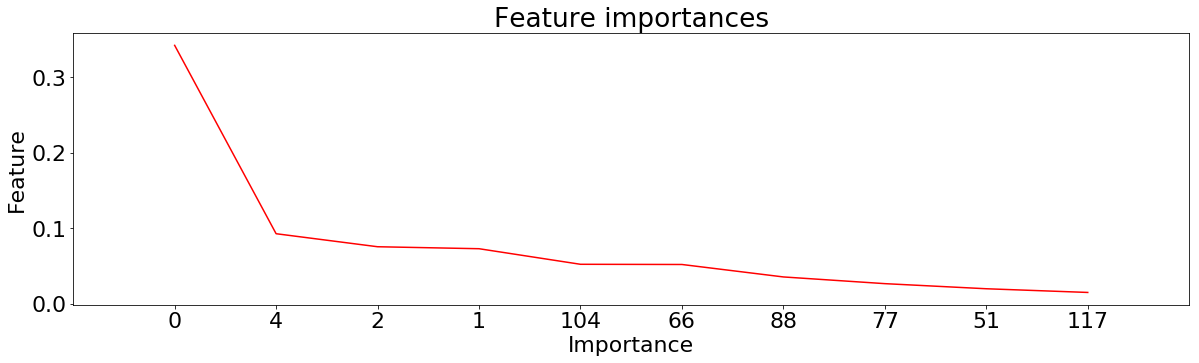

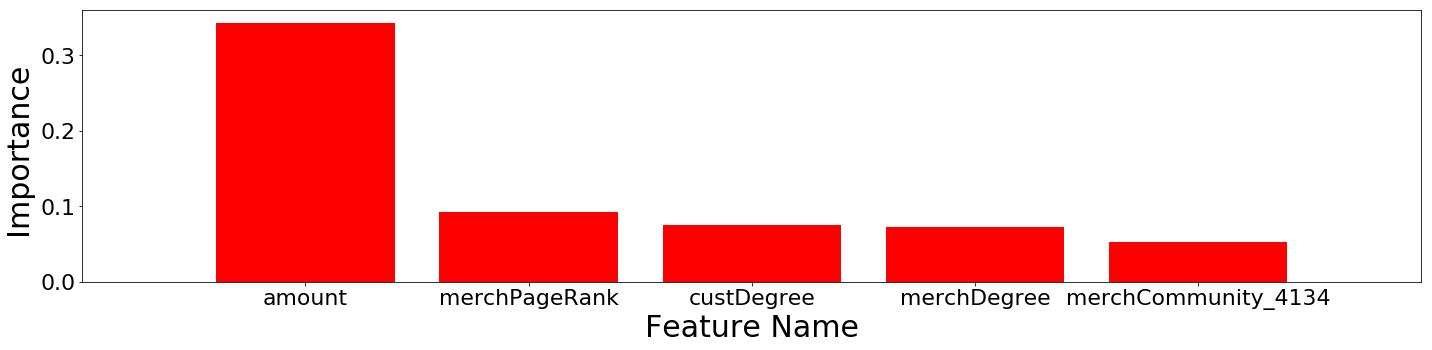

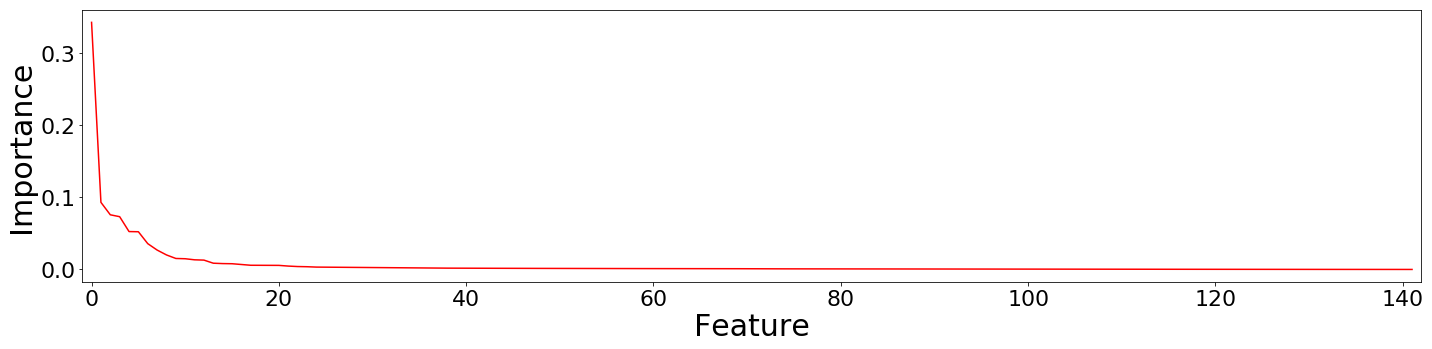

In [213]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 22})
importances = clf_enh.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_enh.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
print("Feature ranking:")

#for f in range(X_train_enh.shape[1]):
#    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    
plt.figure(figsize=(20,5))
plt.title("Feature importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.plot(range(10), importances[indices[0:10]],
       color="r")
plt.xticks(range(10), indices[0:10])
plt.xlim([-1, 10])
plt.show()

plt.figure(figsize=(24,5))
plt.xlabel("Feature Name", fontsize=30)
plt.ylabel("Importance ", fontsize=30)
plt.bar(range(5), importances[indices[0:5]],
       color="r", align="center")
plt.xticks(range(5), features_enhanced.columns[indices[0:5]].get_values())
plt.xlim([-1, 5])
plt.show()


plt.figure(figsize=(24,5))
plt.xlabel("Feature", fontsize=30)
plt.ylabel("Importance", fontsize=30)
plt.plot(range(X_train_enh.shape[1]), importances[indices],
       color="r")

plt.xlim([-1, X_train_enh.shape[1]])
plt.show()



list

numpy.ndarray

In [226]:
training_results_lists = {
    'TP_std' : [],
    'FP_std' : [],
    'TN_std' : [],
    'FN_std' : [],
    'TP_enh' : [],
    'FP_enh' : [],
    'TN_enh' : [],
    'FN_enh' : [],
    'f1_enh' : [],
    'f1_std' : []
}


for o in training_seeds_result:
    training_results_lists['TP_std'].append(o['met_std']['TP'])
    training_results_lists['FP_std'].append(o['met_std']['FP'])
    training_results_lists['TN_std'].append(o['met_std']['TN'])
    training_results_lists['FN_std'].append(o['met_std']['FN'])
    training_results_lists['TP_enh'].append(o['met_enh']['TP'])
    training_results_lists['FP_enh'].append(o['met_enh']['FP'])
    training_results_lists['TN_enh'].append(o['met_enh']['TN'])
    training_results_lists['FN_enh'].append(o['met_enh']['FN'])
    training_results_lists['f1_enh'].append(o['f1_enh'])
    training_results_lists['f1_std'].append(o['f1_std'])

1159.4400000000001

In [245]:
for val in training_results_lists:
    temp_array = np.array(training_results_lists[val])
    training_results_lists[val] = temp_array
    
    print("{}: avg: {} std: {}".format(val, temp_array.mean(), temp_array.std()))

TP_std: avg: 1094.89 std: 24.53197709113556
FP_std: avg: 149.78 std: 13.841661749948955
TN_std: avg: 117339.25 std: 29.279130793109278
FN_std: avg: 345.08 std: 17.202139401830227
TP_enh: avg: 1159.44 std: 24.21624248309386
FP_enh: avg: 149.14 std: 14.240098314267357
TN_enh: avg: 117339.89 std: 29.850257955334317
FN_enh: avg: 280.53 std: 15.600291663940133
f1_enh: avg: 0.8436610457156629 std: 0.00668903418143312
f1_std: avg: 0.8156394210948177 std: 0.006826861271196207


In [259]:
f1_diff = training_results_lists['f1_enh']- training_results_lists['f1_std']
FP_diff = training_results_lists['FP_enh']- training_results_lists['FP_std']
print(f1_diff)

[ 0.02855935  0.02827526  0.03228987  0.022389    0.02775329  0.02451885
  0.0230451   0.0285204   0.03944695  0.03339146  0.03177788  0.03249318
  0.02799311  0.03589449  0.0276802   0.02245358  0.02807736  0.02761444
  0.0197184   0.02818177  0.03370624  0.02509374  0.03237264  0.02506294
  0.03302212  0.03396729  0.03728949  0.02220362  0.02902605  0.02757902
  0.02993034  0.03404389  0.02860125  0.02558992  0.03397087  0.03491101
  0.02674998  0.03116134  0.03505111  0.03003265  0.03064677  0.02201183
  0.02904302  0.02626673  0.02656826  0.03868661  0.02076234  0.02428012
  0.02844942  0.02629568  0.03678797  0.02664123  0.0278629   0.02428888
  0.02873565  0.02572171  0.0296016   0.03325643  0.02201127  0.0289653
  0.03436805  0.03398629  0.01695458  0.02210403  0.0337665   0.03188689
  0.02353953  0.02589617  0.02600702  0.02083466  0.03334984  0.0351032
  0.02545522  0.02700239  0.02906508  0.02075303  0.02149971  0.02940322
  0.03006283  0.02623792  0.02633773  0.02891409  0.0

In [250]:
import scipy as sp
import scipy.stats

# Helper function to create confidence intervals 
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0*np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * sp.stats.t._ppf((1+confidence)/2., n-1)
    return m, m-h, m+h

(0.028021624620845405, 0.026743627760740192, 0.029299621480950618)

In [264]:
tests = ['f1', 'TP', 'TN', 'FP', 'FN']

for test in tests:
    mean, lower, upper = mean_confidence_interval(
        training_results_lists['{}_enh'.format(test)] - training_results_lists['{}_std'.format(test)],
        confidence=0.99)
    print("Test {},  lower: {}, mean:{} upper: {}".format(test,  lower, mean, upper))



Test f1,  lower: 0.026743627760740192, mean:0.028021624620845405 upper: 0.029299621480950618
Test TP,  lower: 61.93226405201534, mean:64.55 upper: 67.16773594798465
Test TN,  lower: -2.2011420211201855, mean:0.64 upper: 3.481142021120186
Test FP,  lower: -3.481142021120186, mean:-0.64 upper: 2.2011420211201855
Test FN,  lower: -67.16773594798465, mean:-64.55 upper: -61.93226405201534


SyntaxError: invalid syntax (<ipython-input-269-37979c33cea4>, line 1)